In [26]:
import sys
from pathlib import Path

project_root = Path("../").resolve()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Force reload of lasernet modules to pick up changes
import importlib
if 'lasernet' in sys.modules:
    importlib.reload(sys.modules['lasernet.dataset.loading'])
    importlib.reload(sys.modules['lasernet.dataset'])
    importlib.reload(sys.modules['lasernet'])

# Data Loading Examples

This notebook demonstrates how to use the `PointCloudDataset` class for loading point cloud data.

In [27]:
import torch
from torch.utils.data import DataLoader
from lasernet.dataset import PointCloudDataset, TemperatureSequenceDataset

## Loading Temperature Data

In [28]:
dataset = PointCloudDataset(
    field="temperature",
    plane="xy",
    split="train",
    plane_index=-1, # top (highest z coordinate)
    axis_scan_files=3  # Scan fewer files for faster initialization
)

print(f"Dataset size: {len(dataset)} samples")
print(f"Data directory: {dataset.data_dir}")
print(f"Total files found: {len(dataset.files)}")
print(f"Plane coordinate (z-axis): {dataset.plane_coord:.8f} (top surface)")
print(f"Dataset shape", dataset.shape)

Dataset size: 17 samples
Data directory: /dtu/blackhole/06/168550/Data
Total files found: 24
Plane coordinate (z-axis): 0.00010000 (top surface)
Dataset shape (17, 1, 187, 929)


Get a single frame

In [29]:
frame = dataset[0]

print("Sample structure:")
print(f"  data shape: {frame['data'].shape}")
print(f"  mask shape: {frame['mask'].shape}")
print(f"  timestep: {frame['timestep']}")
print(f"  width coords: {frame['coords']['width'].shape}")
print(f"  height coords: {frame['coords']['height'].shape}")
print(f"  plane coord: {frame['coords']['plane']}")

# statistics
data = frame['data']
mask = frame['mask']
valid_data = data[:, mask]

print(f"\nStatistics:")
print(f"  min: {valid_data.min():.3f}")
print(f"  max: {valid_data.max():.3f}")
print(f"  mean: {valid_data.mean():.3f}")
print(f"  std: {valid_data.std():.3f}")
print(f"  Coverage: {mask.sum()}/{mask.numel()} pixels ({100*mask.float().mean():.1f}%)")

Sample structure:
  data shape: torch.Size([1, 187, 929])
  mask shape: torch.Size([187, 929])
  timestep: 0
  width coords: torch.Size([929])
  height coords: torch.Size([187])
  plane coord: 9.999999747378752e-05

Statistics:
  min: 300.000
  max: 300.000
  mean: 300.000
  std: 0.000
  Coverage: 130571/173723 pixels (75.2%)


## Visualize Temperature Data

IndexError: index 6 is out of bounds for axis 0 with size 6

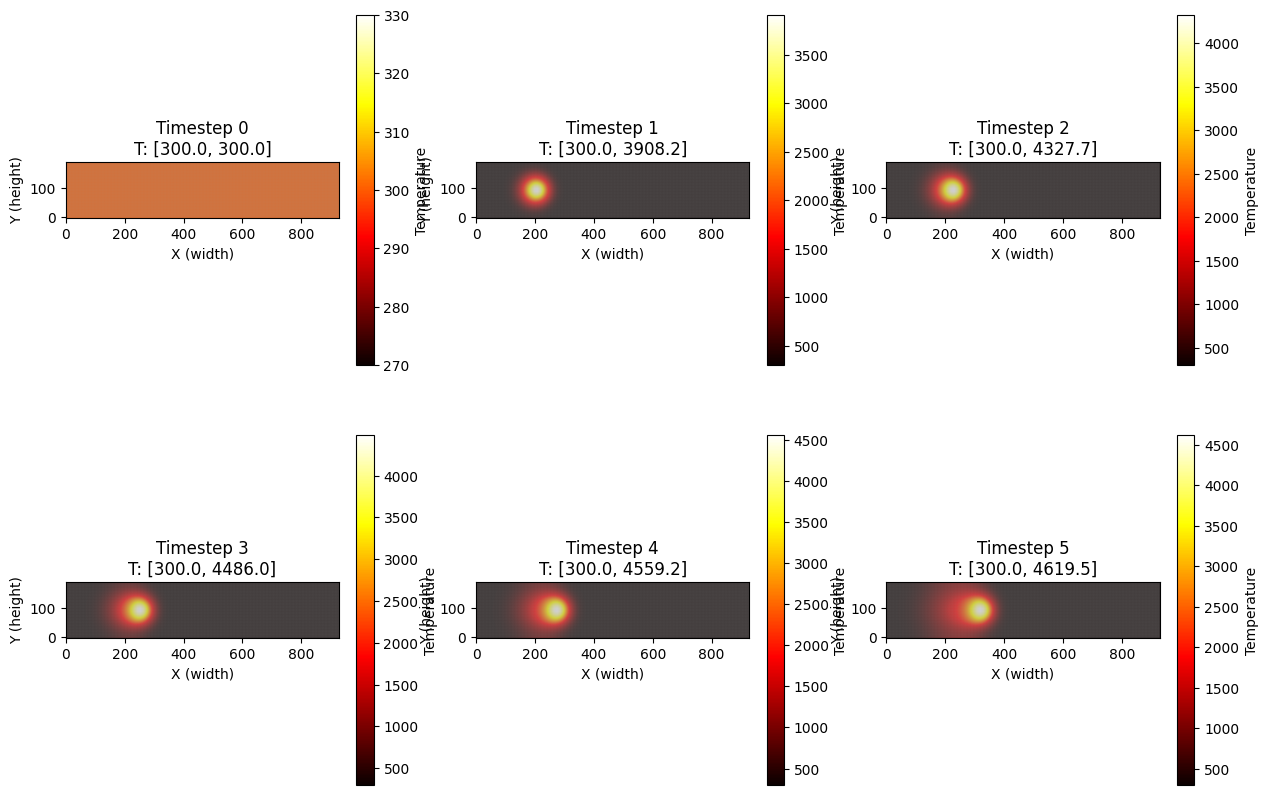

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Load multiple timesteps to find one with interesting temperature data
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, timestep_idx in enumerate(range(16)):
    if timestep_idx >= len(dataset):
        timestep_idx = len(dataset) - 1
    
    sample = dataset[timestep_idx]
    temp_data = sample['data'][0].numpy()  # First (and only) channel
    temp_mask = sample['mask'].numpy()
    
    # Apply mask and get valid data
    temp_data_masked = np.ma.masked_where(~temp_mask, temp_data)
    
    # Get statistics of valid data
    valid_data = temp_data[temp_mask]
    
    ax = axes[i]
    if valid_data.size > 0:
        # Plot with proper color range
        im = ax.imshow(temp_data_masked, cmap='hot', origin='lower', 
                      vmin=valid_data.min(), vmax=valid_data.max())
        plt.colorbar(im, ax=ax, label='Temperature')
        ax.set_title(f'Timestep {sample["timestep"]}\nT: [{valid_data.min():.1f}, {valid_data.max():.1f}]')
    else:
        ax.imshow(temp_mask, cmap='gray', origin='lower')
        ax.set_title(f'Timestep {sample["timestep"]}\n(No valid data)')
    
    ax.set_xlabel('X (width)')
    ax.set_ylabel('Y (height)')

plt.tight_layout()
plt.show()

print("\nDataset info:")
print(f"  Total timesteps available: {len(dataset)}")
print(f"  Timestep indices in this split: {dataset.timesteps}")

### Sliding Window data loading

In [18]:
from lasernet.utils.plot import plot_sliding_window

dataset = TemperatureSequenceDataset(
        split="train",
        sequence_length=3,
        target_offset=1,
        plane_index=-1,
        axis_scan_files=3,
    )

frame = dataset[2]

print("Sample structure:")
print(f"  context shape: {frame['context'].shape}")
print(f"  target shape: {frame['target'].shape}")
print(f"  timestep: {frame['timestep']}")

loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    num_workers=0,
)

print(f"DataLoader created with batch_size=2")
print(f"Total batches: {len(loader)}")


Sample structure:
  context shape: torch.Size([3, 1, 187, 929])
  target shape: torch.Size([1, 187, 929])
  timestep: 2
DataLoader created with batch_size=2
Total batches: 7



Using device: cpu
  data shape: torch.Size([2, 3, 1, 187, 929])
  target shape: torch.Size([2, 1, 187, 929])
  timesteps: [[0, 1, 2], [1, 2, 3]]
  target timestep: [3, 4]


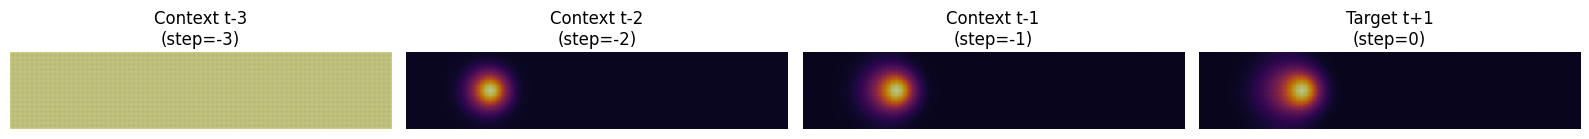

  data shape: torch.Size([2, 3, 1, 187, 929])
  target shape: torch.Size([2, 1, 187, 929])
  timesteps: [[2, 3, 4], [3, 4, 5]]
  target timestep: [5, 6]


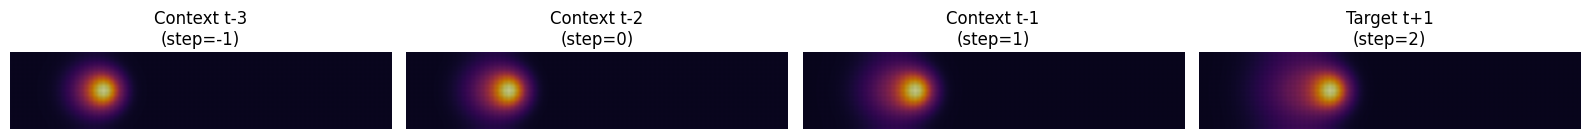

  data shape: torch.Size([2, 3, 1, 187, 929])
  target shape: torch.Size([2, 1, 187, 929])
  timesteps: [[4, 5, 6], [5, 6, 7]]
  target timestep: [7, 8]


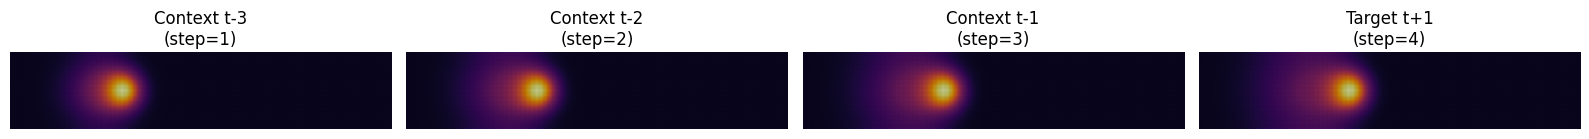

  data shape: torch.Size([2, 3, 1, 187, 929])
  target shape: torch.Size([2, 1, 187, 929])
  timesteps: [[6, 7, 8], [7, 8, 9]]
  target timestep: [9, 10]


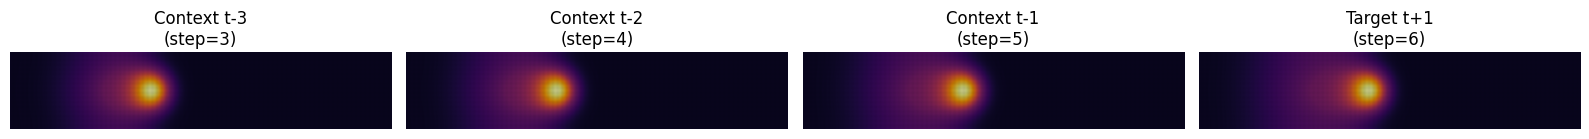

In [21]:
# Get first batch
"""
batch = next(iter(loader))
print(f"\nFirst batch:")
print(f"  data shape: {batch['context'].shape}")  # [4, 1, H, W]
print(f"  target shape: {batch['target'].shape}")  # [4, H, W]
print(f"  timesteps: {batch['timestep'].tolist()}")
"""
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nUsing device: {device}")

# Training loop
for batch in loader:
    context = batch["context"].float().to(device)  # [B, seq_len, 1, H, W]
    target = batch["target"].float().to(device)    # [B, 1, H, W]
    context_timestep = batch['context_timesteps'].to(device)
    target_timestep = batch['target_timestep'].to(device)

    print(f"  data shape: {context.shape}")  # [4, 1, H, W]
    print(f"  target shape: {target.shape}")  # [4, H, W]
    print(f"  timesteps: {context_timestep.tolist()}")
    print(f"  target timestep: {target_timestep.tolist()}")

    plot_sliding_window(batch, window_index=0)

    if context_timestep[0][0] >= 5:
        break

## Use with PyTorch DataLoader

Use PyTorch's `DataLoader` for batched training.

In [ ]:
import torch


loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    num_workers=0,  # Set to >0 for multiprocessing
)

print(f"DataLoader created with batch_size=2")
print(f"Total batches: {len(loader)}")

# Get first batch
batch = next(iter(loader))
print(f"\nFirst batch:")
print(f"  data shape: {batch['data'].shape}")  # [4, 1, H, W]
print(f"  mask shape: {batch['mask'].shape}")  # [4, H, W]
print(f"  timesteps: {batch['timestep'].tolist()}")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nUsing device: {device}")

# Training loop with progress bar
for batch in loader:
    context = batch["context"].float().to(device)  # [B, seq_len, 1, H, W]
    target = batch["target"].float().to(device)    # [B, 1, H, W]
    target_mask = batch["target_mask"].to(device)  # [B, H, W]

DataLoader created with batch_size=4
Total batches: 5

First batch:
  data shape: torch.Size([4, 1, 187, 929])
  mask shape: torch.Size([4, 187, 929])
  timesteps: [3, 15, 14, 16]


## Load All Splits (Train/Val/Test)

In [15]:
# Load all three splits
splits = {}
for split_name in ["train", "val", "test"]:
    splits[split_name] = PointCloudDataset(
        field="temperature",
        plane="xy",
        split=split_name,
        plane_index=-1, # top (highest z coordinate)
        axis_scan_files=3  # Scan fewer files for faster initialization
    )
    print(f"{split_name:5s} set: {len(splits[split_name]):3d} samples")

# Verify they sum to total
total = sum(len(ds) for ds in splits.values())
print(f"\nTotal samples: {total}")

train set:  17 samples
val   set:   4 samples
test  set:   3 samples

Total samples: 24


## Load Different Field Types

Temperature has 1 channel, microstructure has 10 channels (9 IPF components + origin index).

In [16]:
# Temperature data (1 channel)
temp_dataset = PointCloudDataset(
    field="temperature",
    plane="xy",
    split="train",
    plane_index=-1, # top (highest z coordinate)
    axis_scan_files=1  # Scan fewer files for faster initialization
)
temp_sample = temp_dataset[0]
print(f"Temperature data shape: {temp_sample['data'].shape}")
print(f"  Channels: {temp_sample['data'].shape[0]}")

# Microstructure data (10 channels)
micro_dataset = PointCloudDataset(
    field="microstructure",
    plane="xy",
    split="train",
    plane_index=-1, # top (highest z coordinate)
    axis_scan_files=1  # Scan fewer files for faster initialization
)
micro_sample = micro_dataset[0]
print(f"\nMicrostructure data shape: {micro_sample['data'].shape}")
print(f"  Channels: {micro_sample['data'].shape[0]}")
print(f"  (9 IPF components + 1 origin index)")

Temperature data shape: torch.Size([1, 187, 929])
  Channels: 1

Microstructure data shape: torch.Size([10, 187, 929])
  Channels: 10
  (9 IPF components + 1 origin index)


## Load Different Planes (XY, YZ, XZ)

In [18]:
# Load different plane orientations
for plane in ["xy", "yz", "xz"]:
    ds = PointCloudDataset(
        field="temperature",
        plane=plane,
        split="train",
        axis_scan_files=1  # Scan fewer files for faster initialization
    )
    frame = ds[0]
    print(f"{plane.upper()} plane:")
    print(f"  Shape: {frame['data'].shape}")
    print(f"  Width axis: {ds.width_axis}")
    print(f"  Height axis: {ds.height_axis}")
    print(f"  Fixed axis: {ds.fixed_axis} (value: {ds.plane_coord:.6f})")
    print()

XY plane:
  Shape: torch.Size([1, 187, 929])
  Width axis: x
  Height axis: y
  Fixed axis: z (value: 0.000050)

YZ plane:
  Shape: torch.Size([1, 187, 93])
  Width axis: z
  Height axis: y
  Fixed axis: x (value: 0.000500)

XZ plane:
  Shape: torch.Size([1, 93, 929])
  Width axis: x
  Height axis: z
  Fixed axis: y (value: 0.000100)



## Custom Plane Index

You can select a specific plane slice by index (0=first, -1=last, None=middle).

In [19]:
# First slice
dataset_first = PointCloudDataset(
    field="temperature",
    plane="xy",
    split="train",
    plane_index=0,  # First slice
    axis_scan_files=1  # Scan fewer files for faster initialization
)
print(f"First XY slice (index=0): z={dataset_first.plane_coord:.6f}")

# Last slice
dataset_last = PointCloudDataset(
    field="temperature",
    plane="xy",
    split="train",
    plane_index=-1,  # Last slice
    axis_scan_files=1  # Scan fewer files for faster initialization
)
print(f"Last XY slice (index=-1): z={dataset_last.plane_coord:.6f}")

# Middle slice (default)
dataset_middle = PointCloudDataset(
    field="temperature",
    plane="xy",
    split="train",
    plane_index=None,  # Middle slice (default)
    axis_scan_files=1  # Scan fewer files for faster initialization
)
print(f"Middle XY slice (index=None): z={dataset_middle.plane_coord:.6f}")

First XY slice (index=0): z=0.000000
Last XY slice (index=-1): z=0.000100
Middle XY slice (index=None): z=0.000050
